# Tatoeba: N-Gram Hashing

Author: Pierre Nugues

In this notbook, we will reduce the size of the n-gram vectors using hashing techniques

This is a preliminary step to understand language detection and CLD3, https://github.com/google/cld3

In [1]:
import random
from collections import Counter
import torch
import matplotlib.pyplot as plt

In [2]:
random.seed(4321)
torch.manual_seed(4321)

## Reading the Dataset

In [3]:
FILE = 'train.tsv'

In [4]:
SMALL_DATASET_PATH = 'small_dataset'
LARGE_DATASET_PATH = 'large_dataset'

In [5]:
SMALL = False

In [6]:
if SMALL:
    dataset_path = SMALL_DATASET_PATH
else:
    dataset_path = LARGE_DATASET_PATH

WORKING_FILE = dataset_path + '/' + FILE

We create a generator

In [7]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [8]:
line_generator = file_reader(WORKING_FILE)

And we count the sentences per language

In [9]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [10]:
lang_freqs.most_common(15)

[('ukr', 12224),
 ('por', 12172),
 ('dan', 12129),
 ('tok', 12090),
 ('rus', 12088),
 ('epo', 12087),
 ('ron', 12085),
 ('eng', 12073),
 ('ber', 12070),
 ('tgl', 12065),
 ('hau', 12064),
 ('hun', 12062),
 ('mar', 12054),
 ('slk', 12048),
 ('tlh', 12045)]

In [11]:
langs = sorted(list(set(lang_freqs.keys())))
langs[:10]

['ara', 'ber', 'bul', 'ces', 'cmn', 'dan', 'deu', 'ell', 'eng', 'epo']

## Extracting n-grams

In [12]:
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    if lc:
        sentence = sentence.lower()
    for i in range(len(sentence) - n + 1):
        ngram_l += [sentence[i:i+n]]
    return ngram_l

In [13]:
def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [14]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

## Extracting n-grams from the corpus

In [15]:
def extract_ngrams():
    with open(WORKING_FILE, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            lang = lang_tuple[1]
            if lang in langs:
                yield all_ngrams(lang_tuple[2])

We assume three, otherwise we have to create a list

In [16]:
charset = set()
bigram_set = set()
trigram_set = set()

In [17]:
for triple in extract_ngrams():
    charset.update(triple[0])
    bigram_set.update(triple[1])
    trigram_set.update(triple[2])

In [18]:
len(charset), len(bigram_set), len(trigram_set)

(4904, 88783, 300063)

## Hashing the n-grams and limiting their numbers

In [19]:
hash('ads'), hash('ads') % 100

(7027598500612919388, 88)

In [20]:
if SMALL:
    MAX_CHARS = 521
    MAX_BIGRAMS = 1031
    MAX_TRIGRAMS = 1031
else:
    MAX_CHARS = 2053
    MAX_BIGRAMS = 4099
    MAX_TRIGRAMS = 4099  # 8192

In [21]:
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
NUM_FEATURES

10251

In [22]:
def hash_conflicts(symbol_set, modulo):
    conflict_dict = dict()
    for symb in symbol_set:
        hash_code = hash(symb) % modulo
        if hash_code in conflict_dict:
            conflict_dict[hash_code] += [symb]
        else:
            conflict_dict[hash_code] = [symb]
    return conflict_dict

In [23]:
hash_conflicts_1 = hash_conflicts(charset, MAX_CHARS)
hash_conflicts_2 = hash_conflicts(bigram_set, MAX_BIGRAMS)
hash_conflicts_3 = hash_conflicts(trigram_set, MAX_TRIGRAMS)

Expected number of symbols per hash code

In [24]:
len(charset)/MAX_CHARS, len(bigram_set) / \
    MAX_BIGRAMS, len(trigram_set)/MAX_TRIGRAMS

(2.3886994641987336, 21.659673090997803, 73.20395218345938)

In [25]:
hash_conflicts_1[10]

['֜', 'כ']

In [26]:
hash_conflicts_2[100][:10]

['गी', '個空', 'ľn', '命、', 'l:', '还只', '从整', 'の使', 'の充', 'ら辺']

In [27]:
hash_conflicts_3[100][:10]

['qag', 'ر ص', 'а. ', 'の四時', 'سنة', '障礙，', '姆的父', '我的丫', 'て置い', 'が着た']

Observed frequencies

In [28]:
cnt_hc_1 = Counter(map(len, hash_conflicts_1.values()))
cnt_hc_1

Counter({2: 532, 1: 463, 3: 444, 4: 249, 5: 106, 6: 53, 7: 24, 8: 3, 9: 1})

In [29]:
hash_conflicts_1[100]

['ओ', 'á', '乏', '茂', '梦']

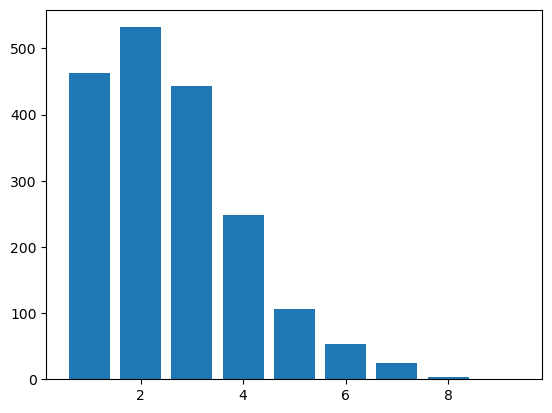

In [30]:
plt.bar(cnt_hc_1.keys(), cnt_hc_1.values())
plt.show()

In [31]:
cnt_hc_2 = Counter(map(len, hash_conflicts_2.values()))
cnt_hc_2

Counter({21: 370,
         20: 348,
         22: 330,
         23: 326,
         19: 303,
         24: 301,
         18: 288,
         25: 240,
         17: 237,
         26: 213,
         16: 180,
         27: 173,
         15: 141,
         28: 137,
         29: 96,
         14: 88,
         30: 55,
         13: 50,
         31: 48,
         32: 39,
         12: 39,
         33: 30,
         11: 19,
         34: 12,
         10: 8,
         35: 7,
         37: 6,
         9: 4,
         36: 4,
         39: 3,
         38: 2,
         8: 1,
         6: 1})

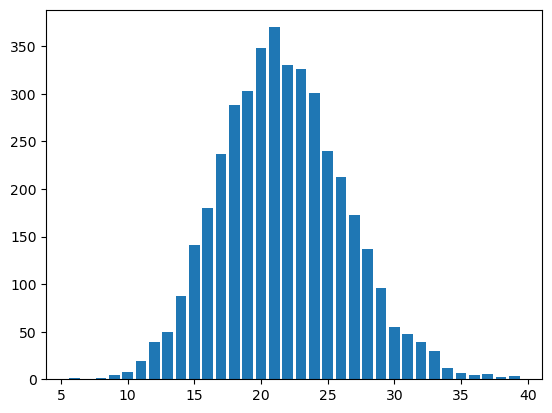

In [32]:
plt.bar(cnt_hc_2.keys(), cnt_hc_2.values())
plt.show()

In [33]:
cnt_hc_3 = Counter(map(len, hash_conflicts_3.values()))

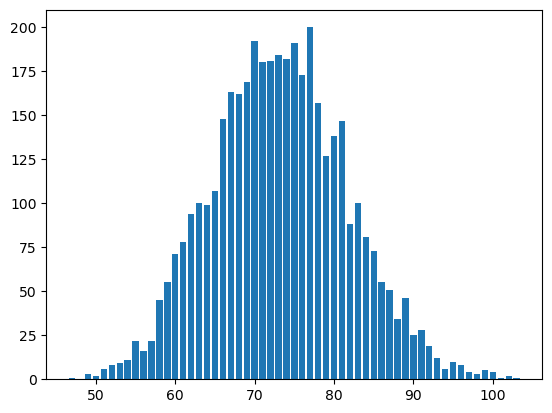

In [34]:
plt.bar(cnt_hc_3.keys(), cnt_hc_3.values())
plt.show()

## Multihot encoding

In [35]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

In [36]:
list(map(lambda x: hash(x) % MAX_TRIGRAMS, all_ngrams('banana')[2]))

[3747, 967, 3005, 967]

In [37]:
MAXES = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

In [38]:
def hash_ngrams(ngrams, modulos):
    hash_codes = []
    for ngram_l, modulo in zip(ngrams, modulos):
        hash_codes += [list(map(lambda x: hash(x) % modulo, ngram_l))]
    return hash_codes

In [39]:
hash_banana = hash_ngrams(all_ngrams('banana'), MAXES)
hash_banana

[[640, 1076, 130, 1076, 130, 1076],
 [3032, 4043, 441, 4043, 441],
 [3747, 967, 3005, 967]]

## Relative Frequencies
CLD3 associates the n-grams with their relative frequencies in the text

In [40]:
def rel_freqs(lst):
    return {ngram: lst.count(ngram)/len(lst)
            for ngram in set(lst)}

In [41]:
list(map(rel_freqs, hash_banana))

[{640: 0.16666666666666666, 130: 0.3333333333333333, 1076: 0.5},
 {3032: 0.2, 441: 0.4, 4043: 0.4},
 {3747: 0.25, 3005: 0.25, 967: 0.5}]

## Multihot vectors

In [43]:
def multihot(idxes, max):
    feat_vector = torch.zeros(max)
    for idx in idxes:
        feat_vector[idx] = 1.0
    return feat_vector

In [44]:
mhot_char_banana = multihot(hash_banana[0], MAX_CHARS)
mhot_char_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [45]:
for i in range(mhot_char_banana.size()[0]):
    if mhot_char_banana[i] == 1.0:
        print(i)

130
640
1076


In [46]:
torch.nonzero(mhot_char_banana)

tensor([[ 130],
        [ 640],
        [1076]])

In [47]:
multihot(hash_banana[1], MAX_BIGRAMS)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [48]:
multihot(hash_banana[2], MAX_TRIGRAMS)

tensor([0., 0., 0.,  ..., 0., 0., 0.])

## Replacing Booleans with Frequencies

In [49]:
def freq_vectorizer(idx_freq, max):
    feat_vector = torch.zeros(max)
    for idx, freq in idx_freq.items():
        feat_vector[idx] = freq
    return feat_vector

In [50]:
freqs_banana = list(map(rel_freqs, hash_banana))
freqs_banana

[{640: 0.16666666666666666, 130: 0.3333333333333333, 1076: 0.5},
 {3032: 0.2, 441: 0.4, 4043: 0.4},
 {3747: 0.25, 3005: 0.25, 967: 0.5}]

In [51]:
freq_char_banana = freq_vectorizer(freqs_banana[0], MAX_CHARS)
freq_char_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [52]:
for i in range(freq_char_banana.size()[0]):
    if freq_char_banana[i]:
        print(i, freq_char_banana[i])

130 tensor(0.3333)
640 tensor(0.1667)
1076 tensor(0.5000)


In [53]:
torch.nonzero(freq_char_banana).T

tensor([[ 130,  640, 1076]])

In [54]:
freq_char_banana[torch.nonzero(freq_char_banana)].T

tensor([[0.3333, 0.1667, 0.5000]])